In [1]:
from fastkaggle import *

In [2]:
comp = 'digitalpathology'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████████████████████████████████████████████████████████████████████████| 39.6M/39.6M [00:00<00:00, 1.21GB/s]

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('./digitalpathology'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./digitalpathology/X_test.npy
./digitalpathology/X.npy
./digitalpathology/Y.npy


In [7]:
from fastai.vision.all import *

In [8]:
path = Path('./digitalpathology')
trn_x = np.load(path/'X.npy')
trn_x.shape

(660, 168, 308)

In [4]:
trn_y = np.load(path/'Y.npy')
trn_y.shape # this is the number of training samples
trn_y[:5]

array([ 7,  5, 17, 16, 11])

(308, 168)


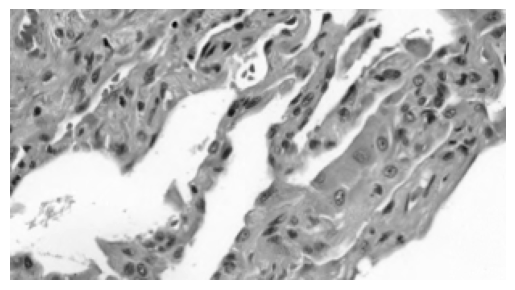

In [5]:
img = Image.fromarray(trn_x[0])
plt.imshow(img, cmap='gray')
plt.axis('off')
print(img.size)

All the images are the same size since their pixel values are contained in the rows of the npy array, which has dims ```(660,308,168)``` .

## Preparing the data for input

I'm going to start with the convnext_tiny_in22k model. It expects an input size of 224x224.

I don't want to convert all the images from the np.array to an image file, which would be necessary if I was using ```fastai.ImageDataLoaders```, so I'm going to go about this differently here:

In [6]:
trn_y_df = pd.DataFrame({'idx': np.arange(len(trn_y)), 'label': trn_y})
trn_y_df.head()

,idx,label
0,0,7
1,1,5
2,2,17
3,3,16
4,4,11


In [7]:
def get_x(row):
    idx = row['idx']
    img_pix = trn_x[idx]
    img_pix = np.stack([img_pix]*3, axis=-1)
    return PILImage.create(img_pix.astype(np.uint8))

In [8]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x,
    get_y=ColReader('label'),
    item_tfms=Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)
)

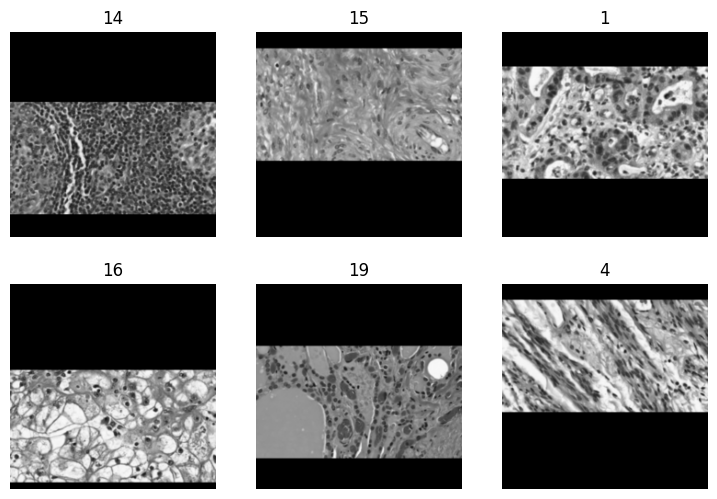

In [9]:
dls = dblock.dataloaders(trn_y_df, bs=64)
dls.show_batch(max_n=6)

## Run the model

I want to start with the ```convnext_tiny_in22k``` model first.

In [10]:
learn = vision_learner(dls, 'convnext_tiny_in22k', metrics=accuracy).to_fp16()

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

In [11]:
learn.fine_tune(3)

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,3.400448,2.400048,0.356061,00:11


epoch,train_loss,valid_loss,accuracy,time
0,1.085060,0.572443,0.863636,00:11
1,0.725696,0.289048,0.909091,00:11
2,0.534003,0.246924,0.916667,00:11


## Let's make the initial submission!

In [12]:
tst_x = np.load(path/'X_test.npy')
tst_x.shape

(300, 168, 308)

In [13]:
tst_dl = learn.dls.test_dl(tst_x)

In [14]:
probs,_ = learn.get_preds(dl=tst_dl)
probs.shape

torch.Size([300, 20])

In [15]:
idxs = np.argmax(probs, axis=1)
idxs.shape

torch.Size([300])

In [16]:
vocab = learn.dls.vocab
preds = pd.Series(vocab[idxs], name='idxs')
preds

0       4
1      16
2       2
3      18
4      11
       ..
295     2
296    11
297     0
298     8
299     8
Name: idxs, Length: 300, dtype: int64

In [17]:
subm = pd.DataFrame({'Id': np.arange(300), 'Class': preds})
subm.head()

,Id,Class
0,0,4
1,1,16
2,2,2
3,3,18
4,4,11


In [18]:
subm.to_csv('sub1.csv', index=False)
!head sub1.csv

Id,Class
0,4
1,16
2,2
3,18
4,11
5,5
6,6
7,10
8,8
